In [ ]:
# hide
# all_tutorial
! [ -e /content ] && pip install -Uqq mrl-pypi  # upgrade mrl on colab

# Example Workflows - Prior Optimization

>Basic prior optimization workflow

## Prior Optimization Workflows

This notebook shows a basic workflow for optimizing a prior distribution relative to a generative model. The focus here is on showing how to set up the code, rather than maximizing performance. For this reason, we will use a simple template and a simple reward function.

During prior optimization, we will create a prior distribution with a specific mean and variance. We will then optimize the weights of the prior while keeping the generative model constant

## Performance Notes

The workflow in this notebook is more CPU-constrained than GPU-constrained due to the need to evaluate samples on CPU. If you have a multi-core machine, it is recommended that you uncomment and run the `set_global_pool` cells in the notebook. This will trigger the use of multiprocessing, which will result in 2-4x speedups.

This notebook may run slow on Collab due to CPU limitations.

In [ ]:
import sys
sys.path.append('..')

from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.templates.all import *

from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.dataloaders import *
from mrl.g_models.all import *
from mrl.vocab import *
from mrl.policy_gradient import *
from mrl.train.all import *
from mrl.model_zoo import *

/home/dmai/miniconda3/envs/mrl/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


## Agent

Here we create the model we want to optimize. We will use the `FP_Cond_LSTM_LM_Small_ZINC` - a LSTM-based conditionl language model pretrained on part of the ZINC database.

Note that for prior optimization we specifically need a conditional generative model

In [ ]:
agent = FP_Cond_LSTM_LM_Small_ZINC(drop_scale=0.5,opt_kwargs={'lr':5e-5}, base_model=None)

Here we freeze the weights of the model so that the model won't be updated during training

In [ ]:
freeze(agent.model)

## Template

We will set up a very basic template that will only check compounds for structural validity

In [ ]:
template = Template([ValidityFilter(), 
                     SingleCompoundFilter()],
                    [])

template_cb = TemplateCallback(template, prefilter=True)

## Reward

For the reward, we will load a scikit-learn linear regression model trained to predict affinity against erbB1 using molecular fingerprints.

This score function is extremely simple and won't translate well to affinity. It is used as a lightweight example

In [ ]:
class FP_Regression_Score():
    def __init__(self, fname):
        self.model = torch.load(fname)
        self.fp_function = partial(failsafe_fp, fp_function=ECFP6)
        
    def __call__(self, samples):
        mols = to_mols(samples)
        fps = maybe_parallel(self.fp_function, mols)
        fps = [fp_to_array(i) for i in fps]
        x_vals = np.stack(fps)
        preds = self.model.predict(x_vals)
        return preds
    
# if in the repo:
reward_function = FP_Regression_Score('../files/erbB1_regression.sklearn')

# if in Collab:
# download_files()
# reward_function = FP_Regression_Score('files/erbB1_regression.sklearn')

reward = Reward(reward_function, weight=1.)

aff_reward = RewardCallback(reward, 'aff')

## Priors

Here we show two ways to set up priors to train

### Method 1: Initialize Priors as Normal Distributions

Here we initialize priors as normal distributions. We create 5 priors with the same initialization. These priors will be trained separately (ie prior 1 won't be trained on samples from prior 2) so the identical initializations aren't an issue

In [ ]:
genbatch = 1500

priors = []
samplers = []

n_priors = 5

for i in range(n_priors):
    prior = SphericalPrior(torch.zeros((agent.model.encoder.d_latent)),
                       torch.zeros((agent.model.encoder.d_latent)),
                       trainable=True)
    priors.append(prior)
    
    prior_loss = PriorLoss(prior)
    
    sampler = PriorSampler(agent.vocab, agent.model, prior, f'prior_{i}', 
                           0, 1./n_priors, genbatch, 
                           train=True, train_all=False, prior_loss=prior_loss,
                           track_losses=False,
                           opt_kwargs={'lr':5e-3})

    samplers.append(sampler)

### Method 2: Initialize Prior from Data

Here we grab 5 high scoring samples from the erbB1 training dataset. We then convert these samples into latent vectors, and use those latent vectors to initialize our priors.

In [ ]:
# if in the repo:
df = pd.read_csv('../files/erbB1_affinity_data.csv')

# if in Collab:
# download_files()
# df = pd.read_csv('files/erbB1_affinity_data.csv')

df = df[df.neg_log_ic50>10]

smiles = df.sample(n=5).smiles.values

print(reward_function(smiles))

[ 9.89236912 10.02078208  9.31949995  8.04805186  9.06363406]


In [ ]:
new_ds = agent.dataset.new(smiles)

batch = collate_ds(new_ds)
x,y = batch

latents = agent.model.x_to_latent(to_device(x))

genbatch = 1500

priors = []
samplers = []

n_priors = latents.shape[0]

for i in range(n_priors):
    prior = SphericalPrior(latents[i],
                       torch.zeros((agent.model.encoder.d_latent))-1,
                       trainable=True)
    priors.append(prior)
    
    prior_loss = PriorLoss(prior)
    
    sampler = PriorSampler(agent.vocab, agent.model, prior, f'prior_{i}', 
                           0, 1./n_priors, genbatch, 
                           train=True, train_all=False, prior_loss=prior_loss,
                           track_losses=False,
                           opt_kwargs={'lr':5e-3})

    samplers.append(sampler)

## Optional: Policy Gradient Loss

The priors we have set so far will be trained by the `PriorLoss` passed to the `PriorSampler`. We can additionally add a policy gradient loss term. This isn't necessary, but tends to speed up convergence.

In [ ]:
losses = []

pg = PolicyGradient(discount=True, gamma=0.97)

loss = PolicyLoss(pg, 'PG')

losses.append(loss)

## Environment

We create our environment with the objects assembled so far

In [ ]:
env = Environment(agent, template_cb, samplers=samplers, rewards=[aff_reward], losses=losses,
                 cbs=[])

## Train

In [ ]:
# set_global_pool(cpus=min(10, os.cpu_count()))

In [ ]:
env.fit(200, 90, 1000, 40)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,prior_0_diversity,prior_0_valid,prior_0_rewards,prior_0_new,prior_1_diversity,prior_1_valid,prior_1_rewards,prior_1_new,prior_2_diversity,prior_2_valid,prior_2_rewards,prior_2_new,prior_3_diversity,prior_3_valid,prior_3_rewards,prior_3_new,prior_4_diversity,prior_4_valid,prior_4_rewards,prior_4_new,aff,PG
0,5.160,5.160,1.000,1.000,197,0.000,0.985,1.000,1.000,5.056,1.000,1.000,0.975,5.403,1.000,1.000,1.000,4.954,1.000,1.000,1.000,5.144,1.000,1.000,0.950,5.253,1.000,5.160,-0.020
40,5.367,5.367,1.000,1.000,199,0.000,0.995,1.000,0.975,5.279,1.000,1.000,1.000,5.145,1.000,1.000,1.000,5.169,1.000,1.000,1.000,5.640,1.000,1.000,1.000,5.600,1.000,5.367,-0.001
80,5.474,5.474,1.000,1.000,199,0.000,0.995,1.000,0.975,5.265,1.000,1.000,1.000,5.553,1.000,1.000,1.000,5.593,1.000,1.000,1.000,5.569,1.000,1.000,1.000,5.385,1.000,5.474,-0.020
120,5.497,5.497,1.000,1.000,195,0.000,0.975,1.000,1.000,5.347,1.000,1.000,0.950,5.556,1.000,1.000,0.950,5.040,1.000,1.000,0.975,5.740,1.000,1.000,1.000,5.790,1.000,5.497,-0.010
160,5.906,5.906,1.000,1.000,196,0.000,0.980,1.000,1.000,5.463,1.000,1.000,0.925,5.930,1.000,1.000,1.000,5.852,1.000,1.000,1.000,6.209,1.000,1.000,0.975,6.082,1.000,5.906,0.001
200,6.050,6.050,1.000,1.000,195,0.000,0.975,1.000,1.000,5.719,1.000,1.000,0.975,6.034,1.000,1.000,1.000,5.955,1.000,1.000,0.950,6.224,1.000,1.000,0.950,6.343,1.000,6.050,0.004
240,6.288,6.288,0.995,1.000,191,0.000,0.955,1.000,1.000,6.197,1.000,1.000,0.950,6.995,1.000,1.000,0.950,5.513,0.974,1.000,0.925,6.218,1.000,1.000,0.950,6.523,1.000,6.288,-0.010
280,6.444,6.444,1.000,1.000,193,0.000,0.965,1.000,0.975,6.099,1.000,1.000,0.925,6.456,1.000,1.000,0.950,6.561,1.000,1.000,1.000,6.122,1.000,1.000,0.975,6.996,1.000,6.444,-0.022
320,6.599,6.599,1.000,1.000,197,0.000,0.985,1.000,0.950,6.132,1.000,1.000,0.975,7.011,1.000,1.000,1.000,6.253,1.000,1.000,1.000,6.823,1.000,1.000,1.000,6.765,1.000,6.599,-0.001
360,6.675,6.675,0.995,1.000,198,0.000,0.990,1.000,1.000,6.382,1.000,1.000,1.000,7.436,0.975,1.000,0.975,6.152,1.000,1.000,1.000,6.763,1.000,1.000,0.975,6.626,1.000,6.675,-0.014


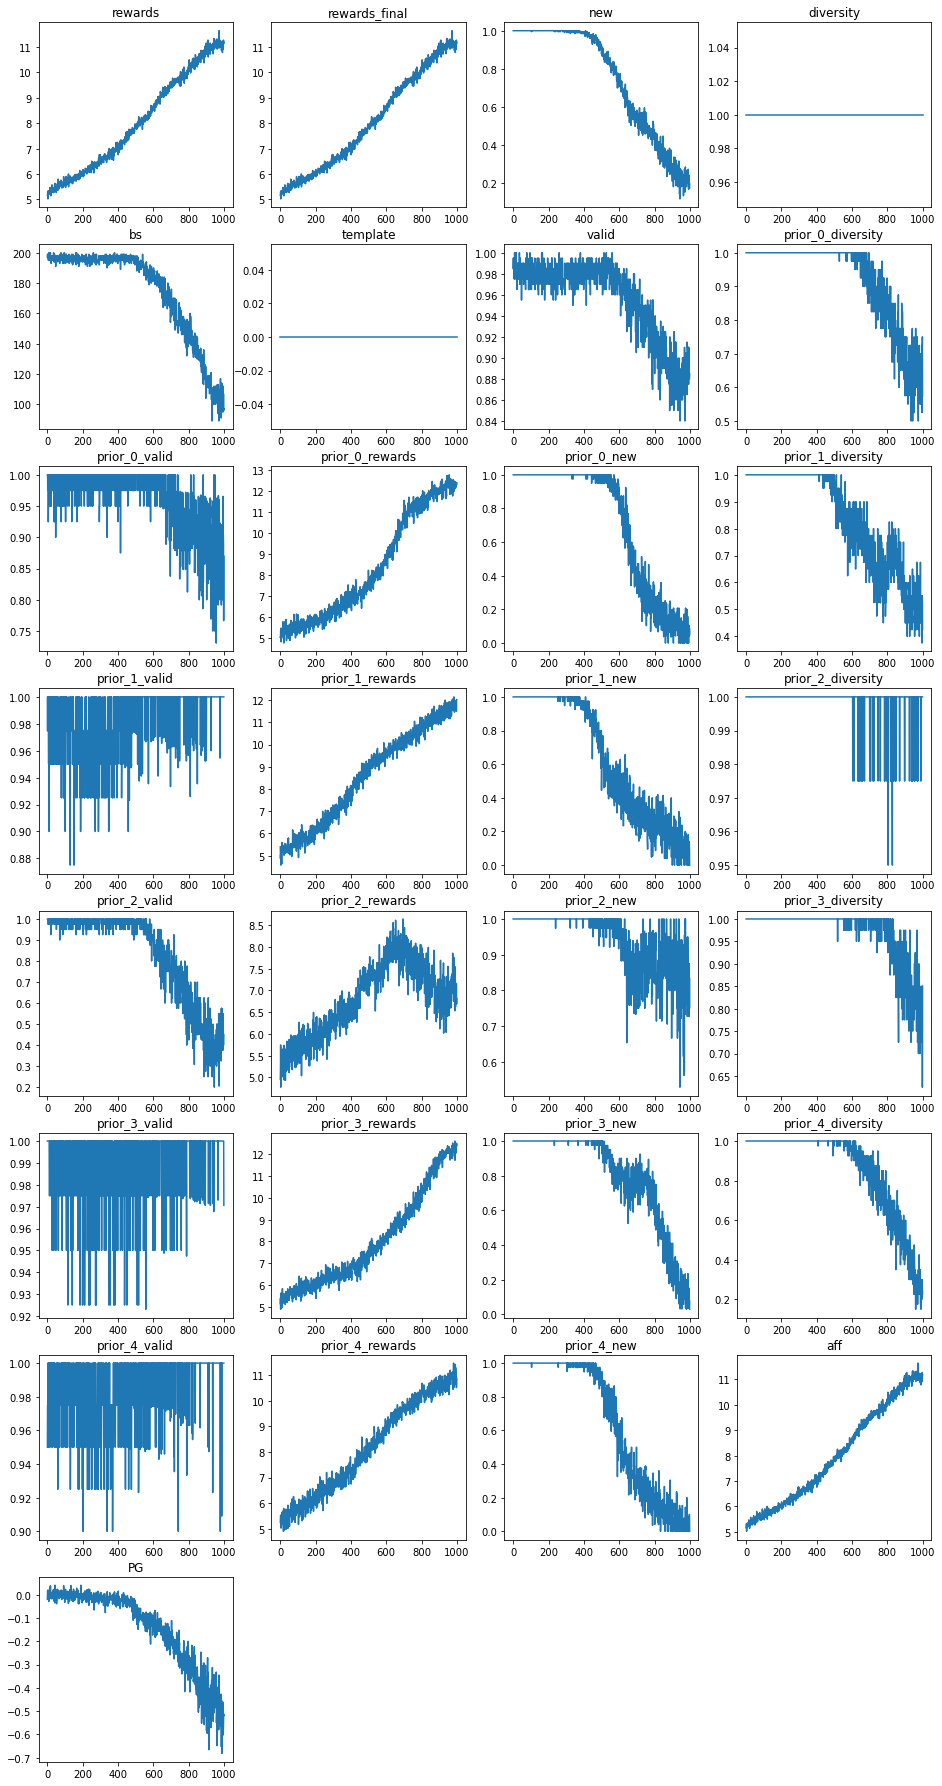

In [ ]:
env.log.plot_metrics()